# Advanced Optimizers
Deep Learning - KI29  
Deggendorf Institute of Technology  
Prof. Dr. Florian Wahl

## Existierende Codebase

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nnfs
from nnfs.datasets import spiral_data

In [2]:
# Dense Layer
class Layer_Dense:

    # Initialization Code
    def __init__(self, n_inputs, n_neurons):
        # Initilalize weights and biases according to the shape given
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs

        # Calculate output as we did on the slides
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [3]:
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs

        # Calculate the output based on inputs.
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        # Copy before we modify
        self.dinputs = dvalues.copy()

        # Set to 0 if value is <=0
        self.dinputs[self.inputs <= 0] = 0

In [4]:
class Loss:
    def calculate(self, output, y):
        # Calculate the per sample loss
        samples_losses = self.forward(output, y)

        # Calculate the mean loss and return it
        loss = np.mean(samples_losses)
        return loss

In [5]:
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        n_samples = len(y_pred)  # Count the samples

        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip the predictions

        # Get correct confidence values
        # if labels are sparse
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(n_samples), y_true]

        # else if labels are one hot encoded
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        # Compute Losses
        losses = -np.log(correct_confidences)
        return losses

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)

        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues

        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [6]:
# Softmax activation
class Activation_Softmax:
    def forward(self, inputs):
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        # Normalize them for each sample
        self.output = probabilities

    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(
            zip(self.output, dvalues)
        ):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(
                single_output, single_output.T
            )

            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [7]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy:
    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):  # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded, # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [8]:
# SGD optimizer
class Optimizer_SGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1.0, decay=0.0, momentum=0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
            )

    # Update parameters
    def update_params(self, layer):
        if self.momentum:
            # If layer has no momentum arrays, create them
            if not hasattr(layer, "weight_momentums"):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Compute weight updates
            weight_updates = (
                self.momentum * layer.weight_momentums
                - self.current_learning_rate * layer.dweights
            )
            layer.weight_momentums = weight_updates

            # Compute bias updates
            bias_updates = (
                self.momentum * layer.bias_momentums
                - self.current_learning_rate * layer.dbiases
            )
            layer.bias_momentums = bias_updates

        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        # Perform update
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

## AdaGrad

### Implementation

```python
cache += parm_gradient ** 2
parm_updates = learning_rate * parm_gradient / (sqrt(cache) + epsilon)
```

1. `cache` holds a history of gradient values (squared to remove sign)
2. During parameter updates, the `cache` value is used to reduce the learning rate

To implement this, we use the `Optimizer_SGD` class from the previous lecture and adapt the update params to
1. Implement the `cache`
2. Apply `cache` to parameter updates
3. Add an epsilon
4. Remove momentum

In [9]:
class Optimizer_Adagrad:
# Initialize optimizer - set settings,
# learning rate of 1. is default for this optimizer 
    def __init__(self, learning_rate=1.0, decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        
    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = \
                self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))
        
    # Update parameters
    def update_params(self, layer):
        # If no cache exists, initialise one
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update the cache
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Update the weights
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
        
    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

### Example

lr: 1.0, epoch: 0, acc: 0.263, loss: 1.099
lr: 0.909, epoch: 1000, acc: 0.660, loss: 0.655
lr: 0.833, epoch: 2000, acc: 0.770, loss: 0.501
lr: 0.769, epoch: 3000, acc: 0.807, loss: 0.439
lr: 0.714, epoch: 4000, acc: 0.837, loss: 0.401
lr: 0.667, epoch: 5000, acc: 0.843, loss: 0.377
lr: 0.625, epoch: 6000, acc: 0.863, loss: 0.357
lr: 0.588, epoch: 7000, acc: 0.863, loss: 0.339
lr: 0.556, epoch: 8000, acc: 0.870, loss: 0.326
lr: 0.526, epoch: 9000, acc: 0.887, loss: 0.309
lr: 0.5, epoch: 10000, acc: 0.897, loss: 0.289


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

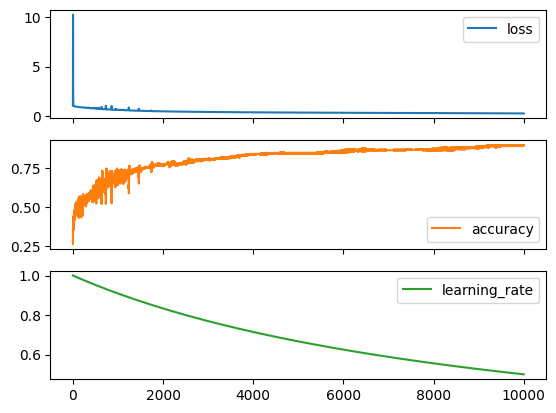

In [10]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer

optimizer = Optimizer_Adagrad(decay=1e-4)

losses = []
accuracies = []
learning_rates = []

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1) 
    accuracy = np.mean(predictions==y)
    if not epoch % 1000: 
        print(f'lr: {round(optimizer.current_learning_rate, 3)}, ' + 
              f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}')
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    losses.append(loss)
    accuracies.append(accuracy)
    learning_rates.append(optimizer.current_learning_rate)
    


df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0:"loss", 1:"accuracy", 2:"learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

## RMSProp

### Implementation

In addition to AdaGrad, RMSProp needs the additional parameter $\rho$ which controls the influence split between the cache history and the current gradient change.
```python
cache = rho * cache + (1 - rho) * gradient ** 2
parm_updates = learning_rate * parm_gradient / (sqrt(cache) + epsilon)
```

1. `cache` holds a history of past changes (moving average) and current gradient change (squared to remove sign). The split is controlled by the hyperparameter $\rho$.
2. During parameter updates, the `cache` value is used to reduce the learning rate

To implement this, we use the `Optimizer_Adagrad` class as a starting point:
1. Add $\rho$
2. Implement the `cache`
2. Apply `cache` to parameter updates (done in AdaGrad already)
3. Add an epsilon (done in AdaGrad already)
4. Remove momentum (done in AdaGrad already)

In [13]:
class Optimizer_RMSprop:
# Initialize optimizer - set settings,
# learning rate of 1. is default for this optimizer 
    def __init__(self, learning_rate=1.0, decay=0., epsilon=1e-7, rho=.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = \
                self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))
        
    # Update parameters
    def update_params(self, layer):
        # If no cache exists, initialise one
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update the cache
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2

        # Update the weights
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
        
    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

### Example

lr: 0.02, epoch: 0, acc: 0.320, loss: 1.099
lr: 0.019, epoch: 1000, acc: 0.730, loss: 0.595
lr: 0.018, epoch: 2000, acc: 0.757, loss: 0.474
lr: 0.017, epoch: 3000, acc: 0.823, loss: 0.381
lr: 0.017, epoch: 4000, acc: 0.893, loss: 0.291
lr: 0.016, epoch: 5000, acc: 0.873, loss: 0.281
lr: 0.015, epoch: 6000, acc: 0.883, loss: 0.265
lr: 0.015, epoch: 7000, acc: 0.893, loss: 0.249
lr: 0.014, epoch: 8000, acc: 0.910, loss: 0.215
lr: 0.014, epoch: 9000, acc: 0.903, loss: 0.216
lr: 0.013, epoch: 10000, acc: 0.910, loss: 0.211


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

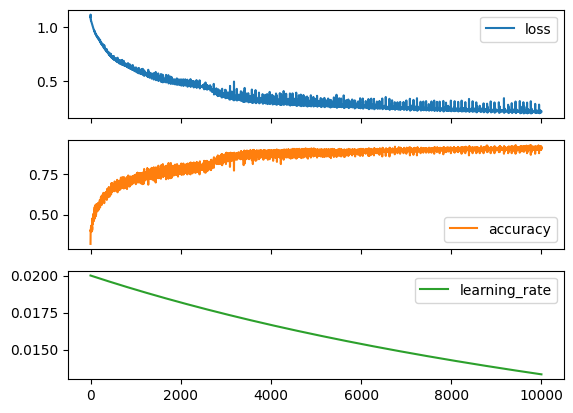

In [17]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer

optimizer = Optimizer_RMSprop(learning_rate=0.02, decay=5e-5, rho=.95)

losses = []
accuracies = []
learning_rates = []

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)

    # Calculate accuracy from output of activation2 and targets # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    if not epoch % 1000:
        print(
            f"lr: {round(optimizer.current_learning_rate, 3)}, "
            + f"epoch: {epoch}, "
            + f"acc: {accuracy:.3f}, "
            + f"loss: {loss:.3f}"
        )
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    losses.append(loss)
    accuracies.append(accuracy)
    learning_rates.append(optimizer.current_learning_rate)


df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

## Adam

### Implementation
Adam is based on RMSProp but adds the momentum concept from the SGD back into it. In adam there are two hyperparameters added, $\beta_1$ and $\beta_2$, where $\beta_1$ is the same as $\rho$ in RMSProp, and $\beta_2$ is the same principle as $\rho$ in RMSprop.

In addition both momentum and cache factors are corrected using the forumla $\mathrm{corrected}=\frac{\mathrm{computed}}{1-\beta^{i}}$ where $i$ is the number of iterations

Steps to perform starting from RMSprop:

1. Rename `rho` to `beta_2`
2. Add `beta1` to constructor
3. Add momentum array to layer
4. Add momentum computation
5. Add momentum correction
6. Add cache correction
7. Update parameter update step

In [20]:
class Optimizer_Adam:
# Initialize optimizer - set settings,
# learning rate of 1. is default for this optimizer 
    def __init__(self, learning_rate=1.0, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = \
                self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))
        
    # Update parameters
    def update_params(self, layer):
        # If no cache exists, initialise one
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            layer.bias_momentums = np.zeros_like(layer.biases)

        # Compute weight momentums 
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Perform momentum correction
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update the cache
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        # Perform cache correction
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Update the weights
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
        
        
    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

lr: 0.05, epoch: 0, acc: 0.323, loss: 1.099
lr: 0.05, epoch: 1000, acc: 0.777, loss: 0.463
lr: 0.05, epoch: 2000, acc: 0.860, loss: 0.366
lr: 0.05, epoch: 3000, acc: 0.893, loss: 0.314
lr: 0.05, epoch: 4000, acc: 0.863, loss: 0.298
lr: 0.05, epoch: 5000, acc: 0.897, loss: 0.267
lr: 0.05, epoch: 6000, acc: 0.873, loss: 0.273
lr: 0.05, epoch: 7000, acc: 0.907, loss: 0.243
lr: 0.05, epoch: 8000, acc: 0.900, loss: 0.242
lr: 0.05, epoch: 9000, acc: 0.910, loss: 0.228
lr: 0.05, epoch: 10000, acc: 0.917, loss: 0.222


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

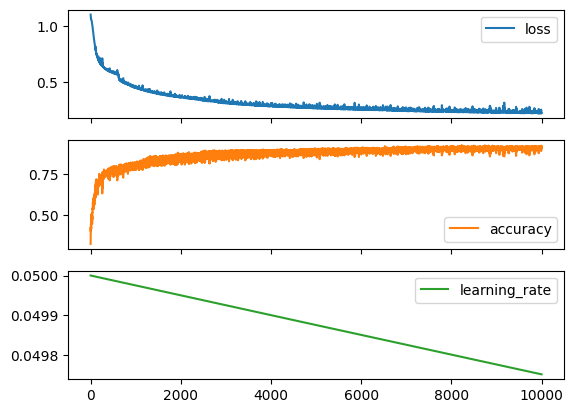

In [26]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer

#optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)
optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)

losses = []
accuracies = []
learning_rates = []

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)

    # Calculate accuracy from output of activation2 and targets # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    if not epoch % 1000:
        print(
            f"lr: {round(optimizer.current_learning_rate, 3)}, "
            + f"epoch: {epoch}, "
            + f"acc: {accuracy:.3f}, "
            + f"loss: {loss:.3f}"
        )
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    losses.append(loss)
    accuracies.append(accuracy)
    learning_rates.append(optimizer.current_learning_rate)


df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

# Testing with new data
So far we evaluated model performance on the training set. We know this is a bad idea, so let's try to evaluate with new, unseen data.

lr: 0.05, epoch: 0, acc: 0.340, loss: 1.099
lr: 0.05, epoch: 1000, acc: 0.817, loss: 0.478
lr: 0.05, epoch: 2000, acc: 0.877, loss: 0.342
lr: 0.05, epoch: 3000, acc: 0.880, loss: 0.299
lr: 0.05, epoch: 4000, acc: 0.877, loss: 0.282
lr: 0.05, epoch: 5000, acc: 0.873, loss: 0.280
lr: 0.05, epoch: 6000, acc: 0.903, loss: 0.242
lr: 0.05, epoch: 7000, acc: 0.900, loss: 0.242
lr: 0.05, epoch: 8000, acc: 0.907, loss: 0.234
lr: 0.05, epoch: 9000, acc: 0.900, loss: 0.241
lr: 0.05, epoch: 10000, acc: 0.913, loss: 0.214
Validation Loss: 0.687, Validation Accuracy: 0.81.


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

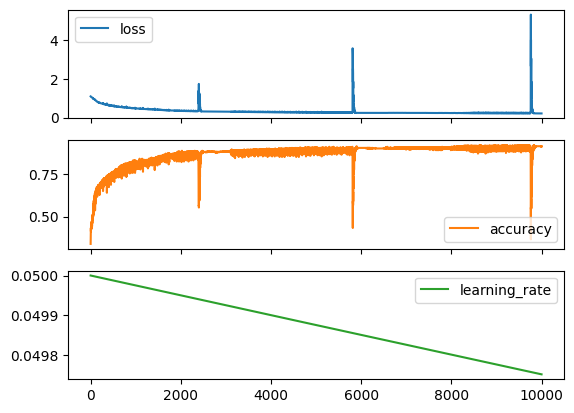

In [30]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer

#optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)
optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)

losses = []
accuracies = []
learning_rates = []

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)

    # Calculate accuracy from output of activation2 and targets # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 1000:
        print(
            f"lr: {round(optimizer.current_learning_rate, 3)}, "
            + f"epoch: {epoch}, "
            + f"acc: {accuracy:.3f}, "
            + f"loss: {loss:.3f}"
        )
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    losses.append(loss)
    accuracies.append(accuracy)
    learning_rates.append(optimizer.current_learning_rate)

X_test, y_test = spiral_data(samples=100, classes=3)

# Perform a forward pass of our training data through this layer
dense1.forward(X_test)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y_test)

# Calculate accuracy from output of activation2 and targets # calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)
print(f"Validation Loss: {round(loss, 3)}, Validation Accuracy: {round(accuracy, 3)}.")
    

df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

Why is validation so much worse?

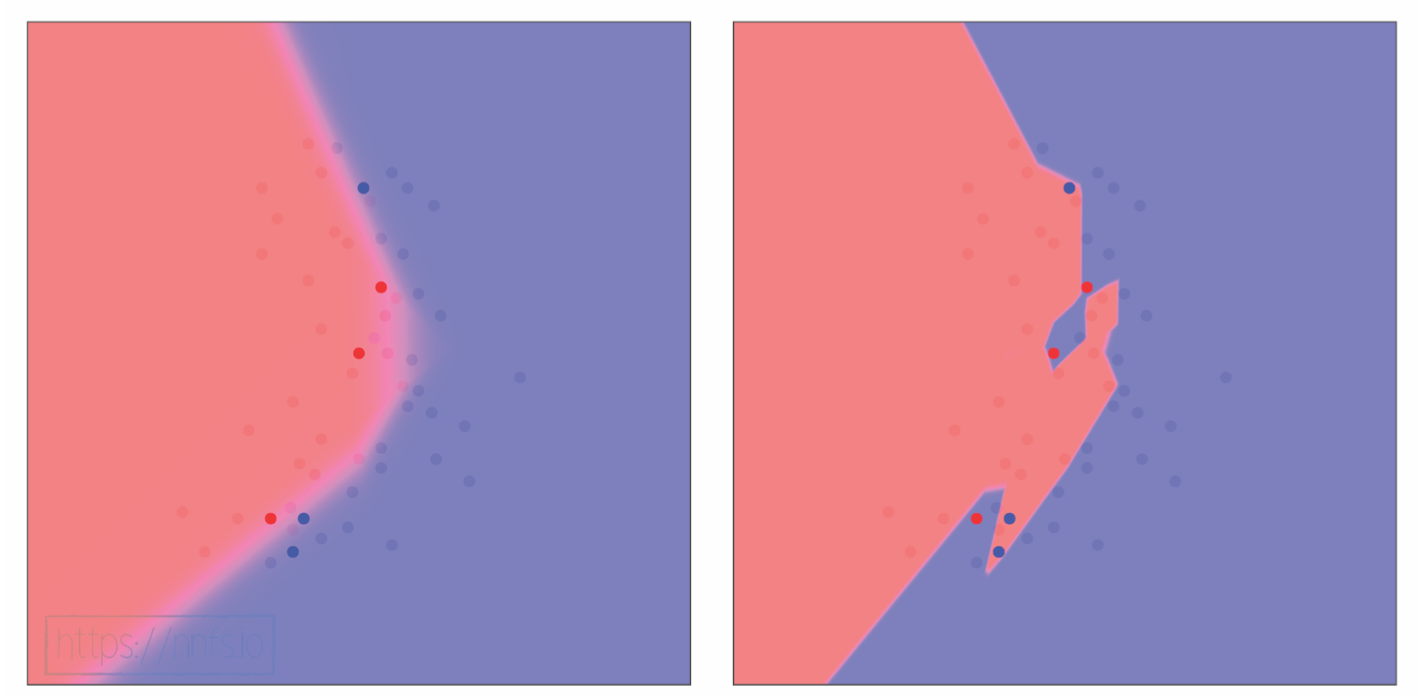

lr: 0.019, epoch: 1000, acc: 0.843, loss: 0.375, cache: 0.000
lr: 0.018, epoch: 2000, acc: 0.907, loss: 0.235, cache: 0.000
lr: 0.017, epoch: 3000, acc: 0.937, loss: 0.197, cache: 0.000
lr: 0.017, epoch: 4000, acc: 0.940, loss: 0.173, cache: 0.000
lr: 0.016, epoch: 5000, acc: 0.940, loss: 0.161, cache: 0.000
lr: 0.015, epoch: 6000, acc: 0.940, loss: 0.151, cache: 0.000
lr: 0.015, epoch: 7000, acc: 0.940, loss: 0.143, cache: 0.000
lr: 0.014, epoch: 8000, acc: 0.940, loss: 0.138, cache: 0.000
lr: 0.014, epoch: 9000, acc: 0.943, loss: 0.133, cache: 0.000
lr: 0.013, epoch: 10000, acc: 0.947, loss: 0.130, cache: 0.000


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

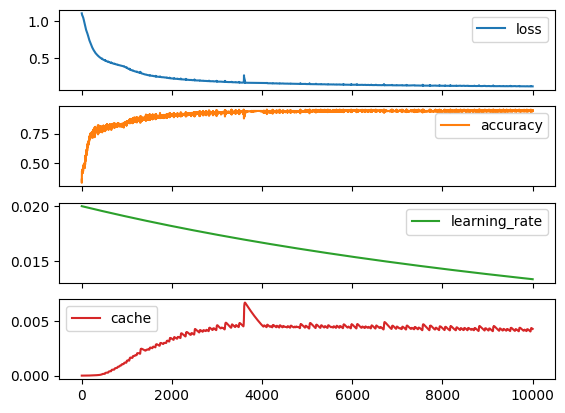

In [49]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer

optimizer = Optimizer_Adam(learning_rate=0.02, decay=5e-5)

losses = []
accuracies = []
learning_rates = []
cache = []

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)

    # Calculate accuracy from output of activation2 and targets # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    if not epoch % 1000 and epoch > 1:
        print(
            f"lr: {round(optimizer.current_learning_rate, 3)}, "
            + f"epoch: {epoch}, "
            + f"acc: {accuracy:.3f}, "
            + f"loss: {loss:.3f}, "
            + f"cache: {dense1.weight_cache[0][0]:.3f}"
        )
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    losses.append(loss)
    accuracies.append(accuracy)
    cache.append(dense2.4.max())
    learning_rates.append(optimizer.current_learning_rate)


df = pd.DataFrame([losses, accuracies, learning_rates, cache]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate", 3: "cache"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

In [45]:
dense1.dweights.max()

np.float64(0.062190888205822664)

Overfitting!

But don't worry we will learn how to deal with it in the next lecture :)